Analysis of historical daily weather data for France dowloaded from  http://www.wunderground.com/history/airport/LFPO/ 

author: victor akinwande

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.set_style('ticks') # graph stying

weather = pd.read_csv('weather_data.csv',parse_dates=['CET'], low_memory = False)

Display the correlation matrix. gaps in the data are filled using linear interpolation

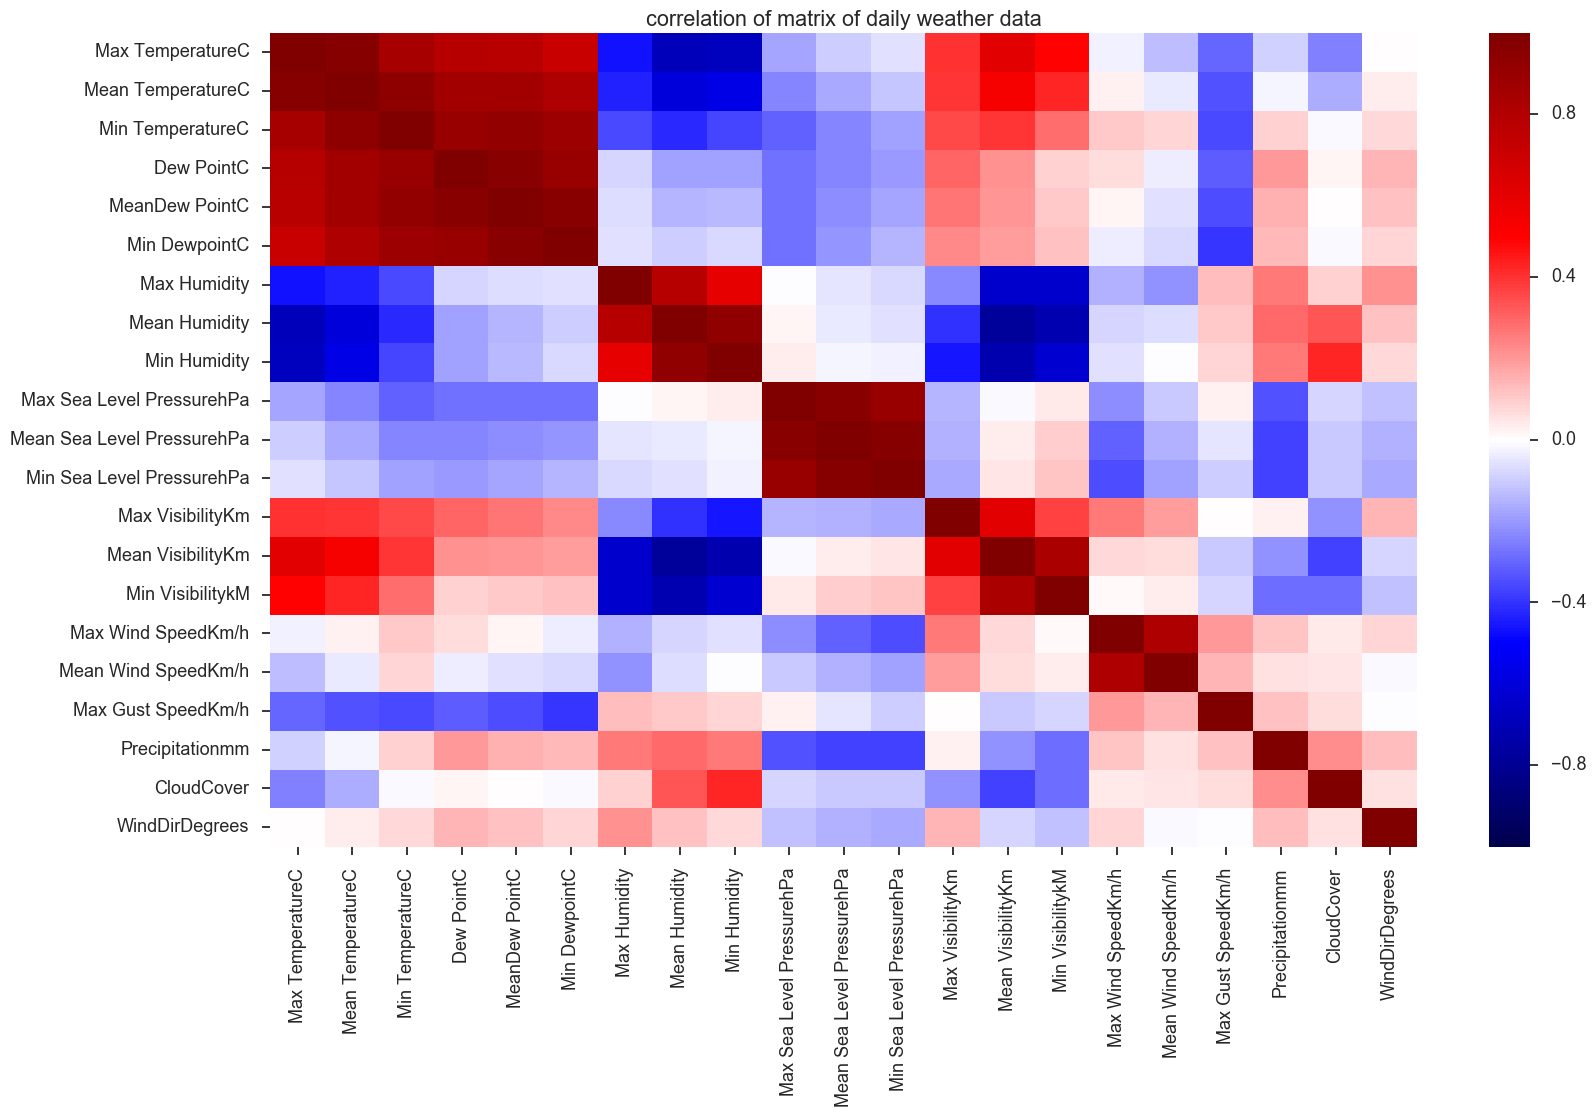

In [43]:

#Rename CET to date

weather['CET'] = pd.to_datetime(weather['CET'])
# drop the events column
weather = weather.drop('Events', axis = 1)

#Fill in the missing gaps(NaNs) with linear interpolation
#For some columns, the first rows are Empty. The trick is to do interpolation
#and then do a backfill thereafter.

weather[['Max Gust SpeedKm/h', 'CloudCover']] = weather[['Max Gust SpeedKm/h', 'CloudCover']].\
astype(float)
weather[['Max Gust SpeedKm/h', 'CloudCover']] = weather[['Max Gust SpeedKm/h', 'CloudCover']].\
interpolate(method='values').fillna(method='bfill')

plot_correlation_matrix(weather)


Analysis of daily electricity consumption data for France downloaded from 

http://clients.rte-france.com/lang/an/visiteurs/vie/vie_stats_conso_jour.jsp
    
Synchronized with the daily weather data


In [37]:
energy_data = pd.read_csv('energy_data_2015.csv')
energy_data = energy_data.drop(['Type de données'], axis = 1)
energy_data['Date'] = pd.to_datetime(energy_data['Date'])

mergedDataset = pd.concat([weather, energy_data], axis=1)


scatter plot of energy consumption against mean temperature

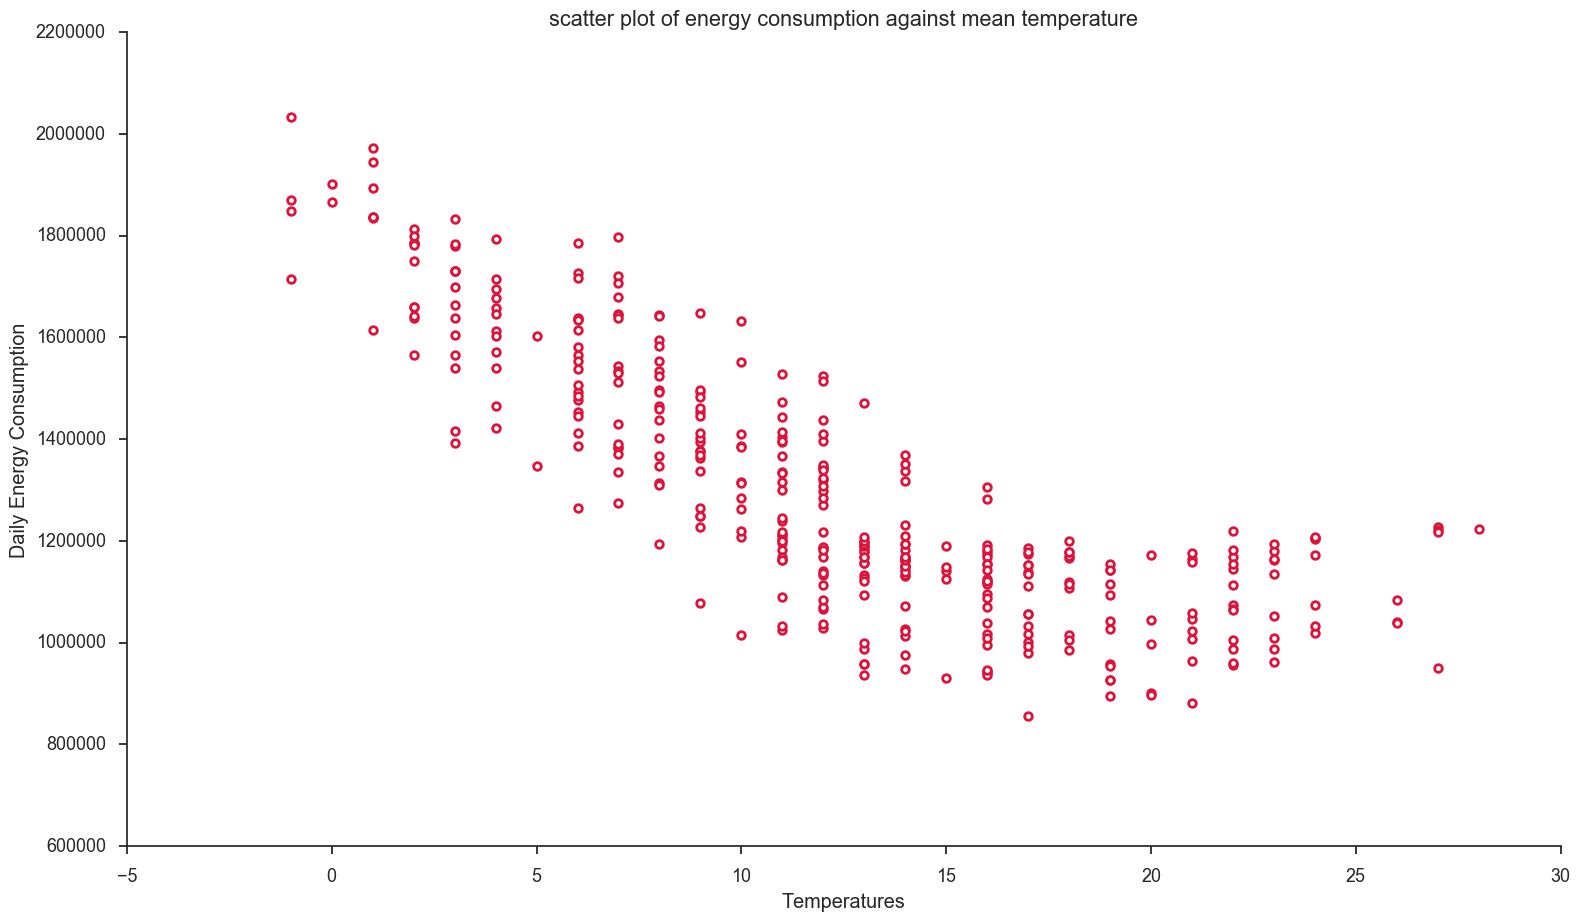

In [45]:
plot_scatterPlot(mergedDataset)

quadratic model fit to the energy versus temperature. 
Plot the quadratic fit as a line on top of the scatter plot.

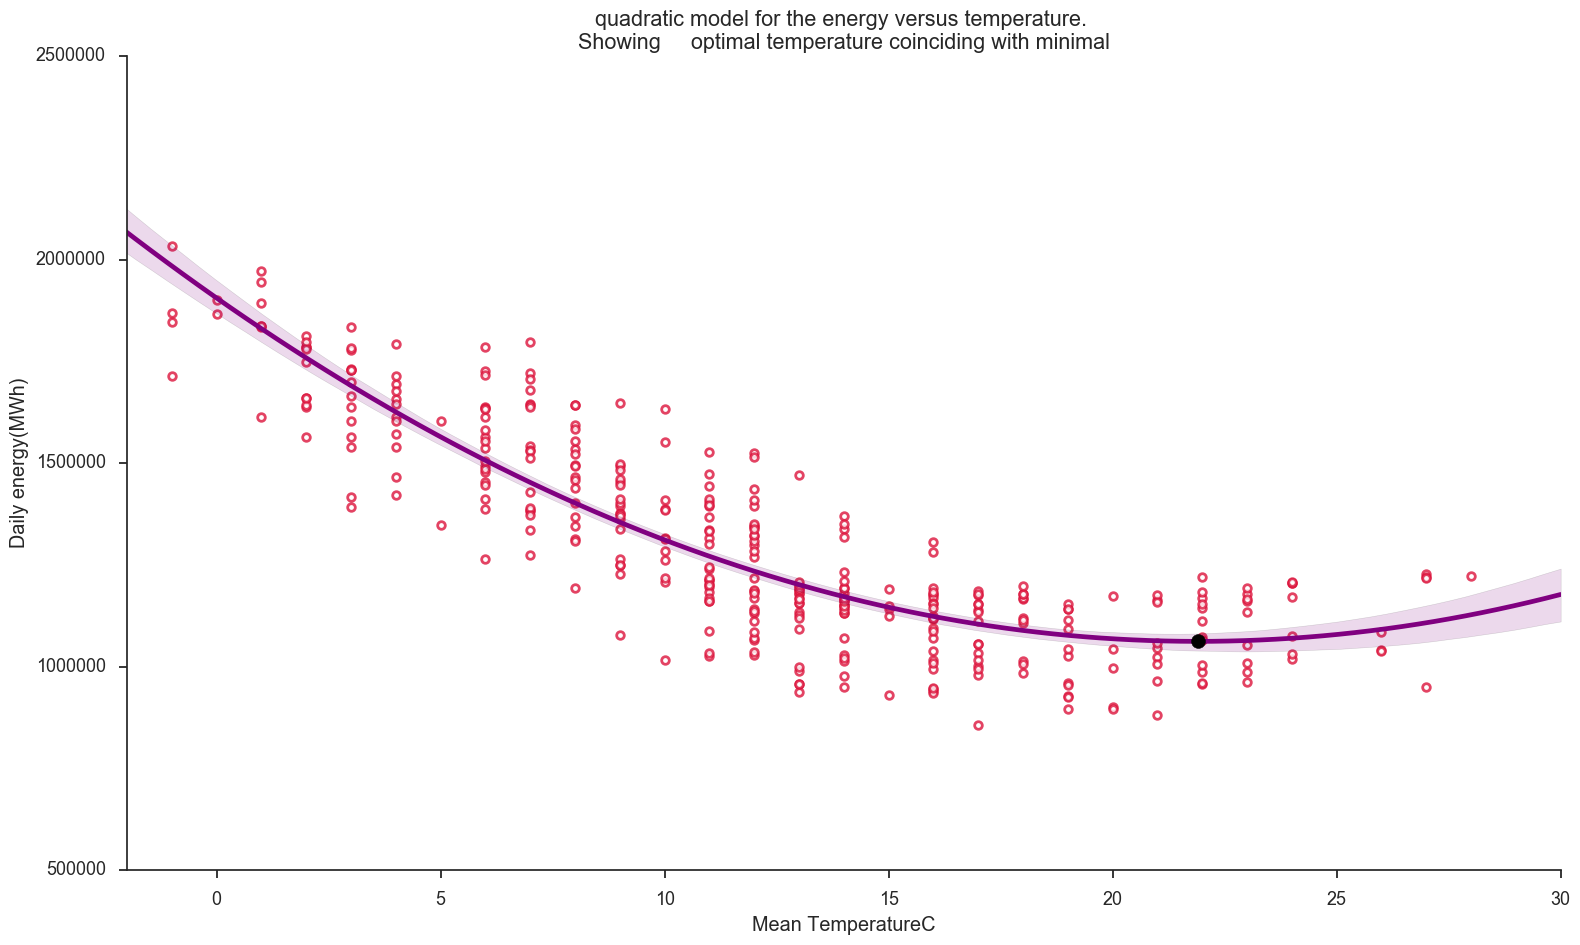

In [50]:
plot_quadraticFit(mergedDataset)

In [ ]:
Clean up  

In [ ]:
saveCleanedDataset(mergedDataset)

cleanAndAddDates(mergedDataset)

In [49]:
def plot_correlation_matrix(weather_data):
    #weather_data = weather_data.drop('Date', axis = 1)
    weather_data = weather_data.drop('CET', axis = 1)
    weather_corr = weather_data.corr()
    sns.set_context(context='talk')
    sns.heatmap(weather_corr, xticklabels = weather_corr.columns.values,
            yticklabels = weather_corr.columns.values, cmap=plt.cm.seismic)
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.title("correlation of matrix of daily weather data")
    plt.show()


def plot_scatterPlot(mergedDataset):
    plt.scatter(mergedDataset['Mean TemperatureC'], mergedDataset['Daily energy(MWh)'], 
                color='white', marker='o',edgecolors='crimson', s=30, linewidths=2)
    plt.ylabel('Daily Energy Consumption')
    plt.xlabel('Temperatures')
    sns.despine()
    plt.title("scatter plot of energy consumption against mean temperature")
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()
    
def plot_quadraticFit(mergedDataset):
    coefficients = np.polyfit(mergedDataset['Mean TemperatureC'], 
                              mergedDataset['Daily energy(MWh)'], 2)
    polynomial = np.poly1d(coefficients)
    
    critical_points = polynomial.deriv().r
    real_part = critical_points[critical_points.imag==0].real
    orjx = polynomial.deriv(2)(real_part)
    
    
    x_min = real_part[orjx>0]
    y_min = polynomial(x_min)

    sns.regplot(x = mergedDataset['Mean TemperatureC'], y = mergedDataset['Daily energy(MWh)'], 
                                            data = mergedDataset, order = 2, color = 'purple',
                                            scatter_kws = {"s":30, "color":"white", 
                                                           "edgecolors":"crimson", "linewidth":2})
    plt.scatter( x_min, y_min, marker='o', color='black', s = 100, zorder=100)
    plt.xlim(-2)
    sns.despine()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.title("quadratic model for the energy versus temperature. \n Showing \
    optimal temperature coinciding with minimal ")
    plt.show()
    
def saveCleanedDataset(mergedDataset):
    mergedDataset =mergedDataset.drop('Date', axis = 1)
    mergedDataset =mergedDataset.drop('CET', axis = 1)
    mergedDataset.to_csv('weather_energy_merged.csv')
    
    # Square the exploratory variables

    squared_values = mergedDataset.drop('Daily energy(MWh)', axis = 1)
    squared_values = squared_values.add_suffix('_squared')
    for k in squared_values.keys():
        squared_values[k] = squared_values[k]**2
        
    weather_energy_merged_squared = pd.concat([mergedDataset, squared_values],axis=1)
    weather_energy_merged_squared.to_csv('weather_energy_merged_squared.csv')
    

def cleanAndAddDates(mergedDataset):
    mergedDataset['DayOfWeek'] = mergedDataset['Date'].dt.weekday_name
    weekDaysHotEncoded = pd.get_dummies(mergedDataset['DayOfWeek'])
    weekDaysHotEncoded = weekDaysHotEncoded.astype(np.int8)
    mergedDataset = mergedDataset.drop('DayOfWeek', axis = 1)
    mergedDataset = mergedDataset.drop('Date', axis = 1)
    mergedDataset = mergedDataset.drop('CET', axis = 1)
    weather_energy_wkdays = pd.concat([mergedDataset, weekDaysHotEncoded], axis=1)
    weather_energy_wkdays.to_csv('weatherSquared_energy_wkdays.csv')